# Extract train-dev-test csv datasets from BigQuery using dataframe

In [131]:
import google.datalab.bigquery as bq
import pandas as pd
import numpy as np
import seaborn as sns
import shutil

In [132]:

def sample_between(a, b):
  basequeryX = """
  SELECT 
    answer_count, comment_count, favorite_count,  score, view_count,
    TIMESTAMP_DIFF(last_activity_date, creation_date, DAY) as days_posted,
    IF(accepted_answer_id IS NULL , 0, 1) as accepted,
    (IF(answer_count IS NULL , 0, answer_count*2) 
    + IF(comment_count IS NULL , 0, comment_count)  
    + IF(favorite_count IS NULL , 0, favorite_count)  
    + IF(score IS NULL , 0, score)  
    + IF(view_count IS NULL , 0, view_count*2) ) 
    as total_score
  FROM 
    `bigquery-public-data.stackoverflow.posts_questions`
  """
  basequery = """
  SELECT 
    answer_count, comment_count, favorite_count,  score, view_count,
    TIMESTAMP_DIFF(last_activity_date, creation_date, DAY) as days_posted,
    IF(accepted_answer_id IS NULL , 0, 1) as accepted
  FROM 
    `bigquery-public-data.stackoverflow.posts_questions`
  """
  sampler = "WHERE MOD(ABS(FARM_FINGERPRINT(CAST(id as STRING))), EVERY_N * 100) <= 10"
  sampler2 = "AND {0} >= {1}\n AND {0} < {2}".format(
           "MOD(ABS(FARM_FINGERPRINT(CAST(id AS STRING))), EVERY_N * 100) * {}".format(10),
           a, b
          )
  return "{}\n{}\n{}".format(basequery, sampler, sampler2)


def create_query(phase, EVERY_N):
  """Phase: train (70%) valid (15%) or test (15%)"""
  query = ""
  if phase == 'train':
    query = sample_between(0,70)
  elif phase == 'valid':
    query = sample_between(70,85)
  else:
    query = sample_between(85,100)
  return query.replace("EVERY_N", str(EVERY_N))

#print(create_query('train', 100))
#(answer_count - AVG(answer_count)) / STDDEV_POP(answer_count)  as answer_count,

In [133]:
def to_csv(df, filename):
  outdf = df.copy(deep = False)
  #outdf.loc[:, 'key'] = np.arange(0, len(outdf)) # rownumber as key
  # Reorder columns so that target is first column
  cols = outdf.columns.tolist()
  #print(cols)
  cols.remove('accepted')
  cols.insert(0, 'accepted')
  #print(cols)
  outdf = outdf[cols]  
  
  
  #Normalizing input columns  and replace NaN or null
  normalize_cols = outdf.columns.tolist()
  normalize_cols.remove('accepted')
  for normalize_cols_name in normalize_cols:
    outdf[normalize_cols_name].fillna(0, inplace = True)
    outdf[normalize_cols_name] = (outdf[normalize_cols_name] - outdf[normalize_cols_name].mean())  / outdf[normalize_cols_name].std() 
  #print(outdf)
  #print(outdf['answer_count'] )
  outdf.to_csv(filename,  header = True, index_label = False, index = False)
  print("Wrote {} to {}".format(len(outdf), filename))

In [134]:

for phase in ['train', 'valid', 'test']:
  query = create_query(phase, 100)
  df = bq.Query(query).execute().result().to_dataframe()
  to_csv(df, 'stackoverflow-{}.csv'.format(phase))

Wrote 11953 to stackoverflow-train.csv
Wrote 3390 to stackoverflow-valid.csv
Wrote 1695 to stackoverflow-test.csv


In [135]:
!ls -l *.csv

-rw-r--r-- 1 root root  210714 May 15 08:53 stackoverflow-test.csv
-rw-r--r-- 1 root root 1480362 May 15 08:53 stackoverflow-train.csv
-rw-r--r-- 1 root root  422326 May 15 08:53 stackoverflow-valid.csv


In [136]:
%bash
head stackoverflow-train.csv

accepted,answer_count,comment_count,favorite_count,score,view_count,days_posted
0,3.9761771771819374,-0.36718938983323063,0.2833788752885213,0.5469038733628567,0.579738232127256,0.5827299894628355
1,4.702249556399996,0.7567580561787042,0.2833788752885213,0.36567737061445144,0.15036188995453023,2.0421307100805812
0,6.880466694054173,0.7567580561787042,-0.11568188064028351,-0.11759330338129602,-0.04326097738308926,4.187198148574768
1,3.9761771771819374,0.0074597588374143015,1.2810307651105335,1.0301745473586041,0.2926400651986819,1.0922621376095485
1,6.154394314836114,-0.36718938983323063,15.64721797854751,12.628670723256542,7.410298006655664,6.734858889308334
1,3.9761771771819374,-0.36718938983323063,1.2810307651105335,1.0905833816080726,0.6205343859936004,4.489143125254302
0,3.9761771771819374,-0.36718938983323063,1.6800915210393383,0.9093568788596672,0.13816117104123096,3.9942888579183995
1,3.9761771771819374,-0.7418385385038755,0.0838484973241189,-0.11759330338129602,0.25289241061394

# tf.estimator modeling

In [56]:
# Ensure that we have TensorFlow 1.13.1 installed.
!pip3 freeze | grep tensorflow==1.13.1 || pip3 install tensorflow==1.13.1

tensorflow==1.13.1


In [137]:
import tensorflow as tf
import pandas as pd
import shutil

print(tf.__version__)

1.8.0


In [138]:
!ls -l *.csv

-rw-r--r-- 1 root root  210714 May 15 08:53 stackoverflow-test.csv
-rw-r--r-- 1 root root 1480362 May 15 08:53 stackoverflow-train.csv
-rw-r--r-- 1 root root  422326 May 15 08:53 stackoverflow-valid.csv


In [139]:
df_train = pd.read_csv(filepath_or_buffer = "./stackoverflow-train.csv")
df_valid = pd.read_csv(filepath_or_buffer = "./stackoverflow-valid.csv")
df_test = pd.read_csv(filepath_or_buffer = "./stackoverflow-test.csv")

CSV_COLUMNNAMES = list(df_train) # CSV_COLUMNNAMES = df_train.columns.tolist()
print(CSV_COLUMNNAMES)

FEATURE_NAMES = CSV_COLUMNNAMES[1:]
LABEL_NAME = CSV_COLUMNNAMES[0]

['accepted', 'answer_count', 'comment_count', 'favorite_count', 'score', 'view_count', 'days_posted']


In [140]:
featcols = [ tf.feature_column.numeric_column(feat) for feat in  FEATURE_NAMES ]
#print(featcols)

In [141]:
def pandas_input_3(df, phase, batch_size = 128):
  dataset = tf.data.Dataset.from_tensor_slices(tensors = ( dict(df[FEATURE_NAMES]), df[LABEL_NAME] )  )
  if(phase == 'train'):
    #return tf.estimator.inputs.pandas_input_fn(x = dict(df[FEATURE_NAMES]), y= df[LABEL_NAME], batch_size = batch_size, num_epochs = 10, shuffle = True, queue_capacity = 1000)
    dataset = dataset.shuffle(buffer_size = 1000).repeat(count=None).batch(batch_size = batch_size)
    return dataset
  else:
    #return tf.estimator.inputs.pandas_input_fn(x = dict(df[FEATURE_NAMES]), y= df[LABEL_NAME], batch_size = batch_size)
    dataset = dataset.batch(batch_size = batch_size)
    return dataset

In [143]:
%%time
OUTDIR = "stack_trained"

tf.logging.set_verbosity(tf.logging.INFO)
shutil.rmtree(path = OUTDIR, ignore_errors = True)

model = tf.estimator.DNNLinearCombinedClassifier(
    dnn_hidden_units = [1024, 512, 128, 32],  # specify neural architecture
    dnn_feature_columns = featcols,
    n_classes=2,
    #optimizer = tf.train.AdamOptimizer(learning_rate=0.001),
    model_dir = OUTDIR,
    config = tf.estimator.RunConfig(tf_random_seed = 1)  
  )

model.train(
    input_fn = lambda : pandas_input_3(df = df_train, phase = 'train'),
    steps = 500
  )

INFO:tensorflow:Using config: {'_session_config': None, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_global_id_in_cluster': 0, '_master': '', '_save_checkpoints_secs': 600, '_save_summary_steps': 100, '_task_id': 0, '_is_chief': True, '_log_step_count_steps': 100, '_evaluation_master': '', '_train_distribute': None, '_model_dir': 'stack_trained', '_service': None, '_task_type': 'worker', '_keep_checkpoint_max': 5, '_tf_random_seed': 1, '_keep_checkpoint_every_n_hours': 10000, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb37dcd2518>, '_save_checkpoints_steps': None}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into stack_trained/model.ckpt.
INFO:tensorflow:step = 1, loss = 90.033035
INFO:tensorflow:global_step/sec:

In [144]:
def validate_rmse(model, df_validation):
  metrices = model.evaluate(input_fn = lambda : pandas_input_3(df_validation, 'valid') )
  print("RMSE on dataset = {}".format(metrices["average_loss"]**.5))

#validate_rmse(model, df_train)
validate_rmse(model, df_valid)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-05-15-08:56:25
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from stack_trained/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-05-15-08:56:26
INFO:tensorflow:Saving dict for global step 500: accuracy = 0.6584071, accuracy_baseline = 0.53539824, auc = 0.72175974, auc_precision_recall = 0.7122374, average_loss = 0.64412177, global_step = 500, label/mean = 0.53539824, loss = 80.87306, precision = 0.61418146, prediction/mean = 0.6250278, recall = 0.9735537
RMSE on dataset = 0.8025719694148264


Evaluation on DNNClassifier:

INFO:tensorflow:Saving dict for global step 500: accuracy = 0.67256635, accuracy_baseline = 0.53539824, auc = 0.7225628, auc_precision_recall = 0.7064935, average_loss = 0.6034251, global_step = 500, label/mean = 0.53539824, loss = 75.763374, precision = 0.66044605, prediction/mean = 0.5127091, recall = 0.799449
RMSE on dataset = 0.7768044062340186

In [145]:
raw_predictions = model.predict( input_fn = lambda : pandas_input_3( df_test , 'test' ) )

#print(next(raw_predictions))
#print(next(raw_predictions))
#print(next(raw_predictions))
# class_ids determine the prediction

predictions = [p['class_ids'][0] for p in raw_predictions]

#confusion_matrix = tf.confusion_matrix(df_test['accepted'], predictions)
#print(confusion_matrix)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from stack_trained/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [146]:
df_test_predictions = df_test.copy(deep = True)
df_test_predictions['accepted'] = predictions

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


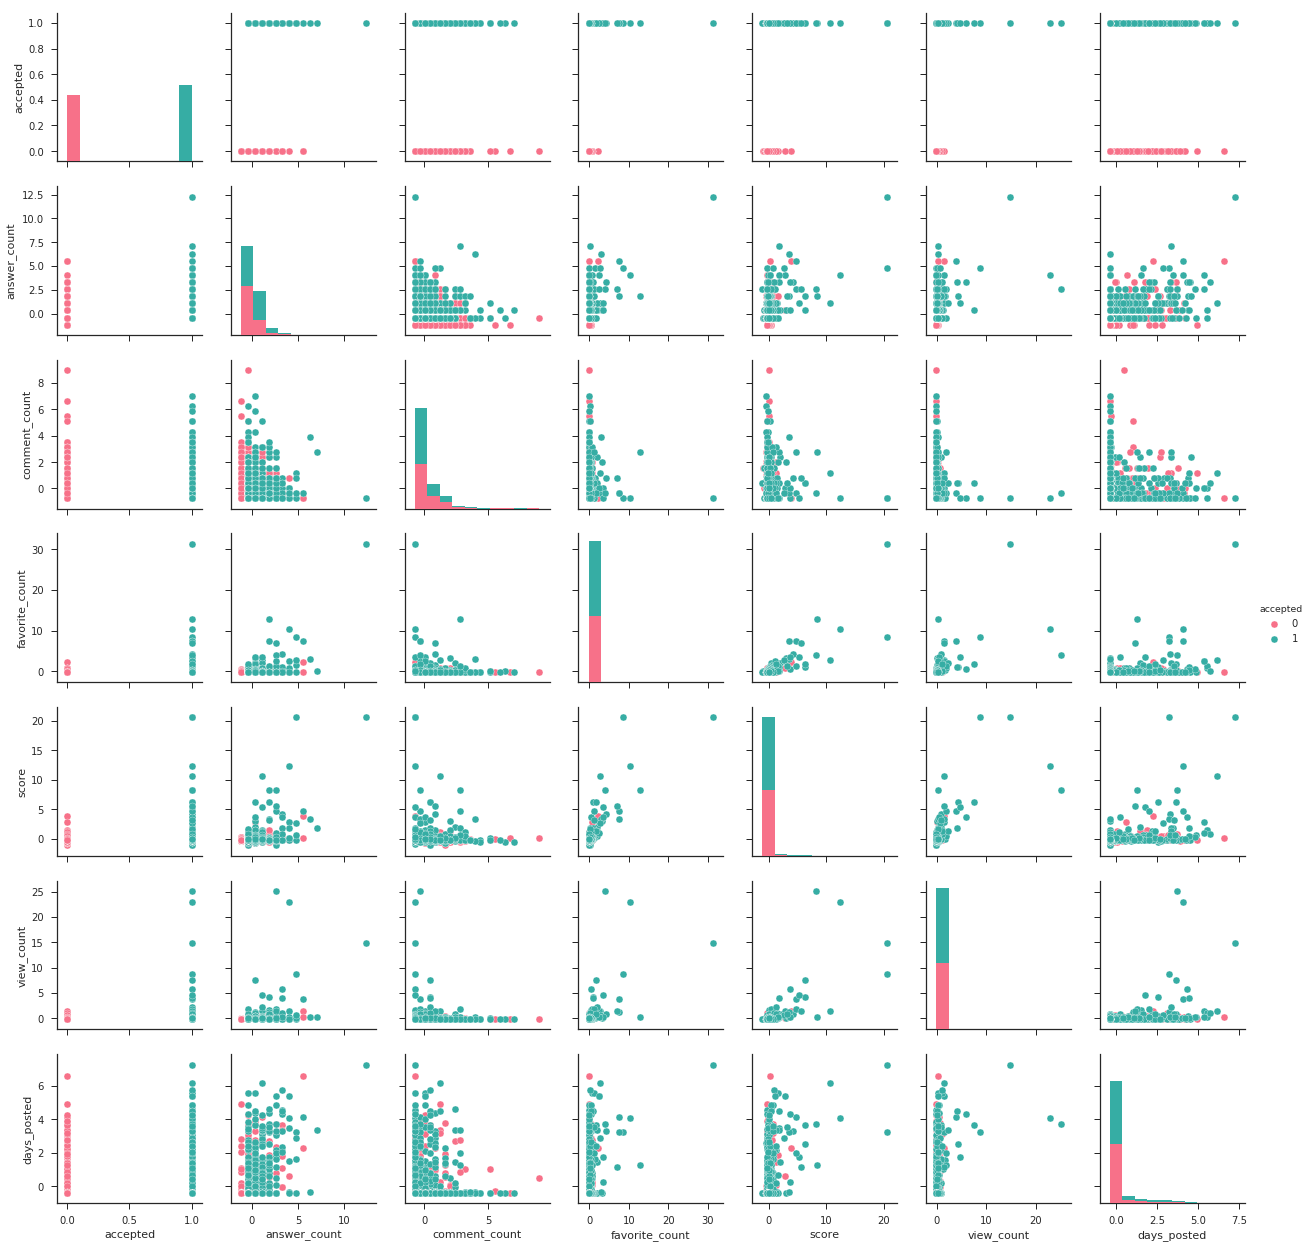

In [147]:
#sns.set(style="ticks", color_codes=True)
sns.pairplot(df_test, hue="accepted", palette="husl")

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


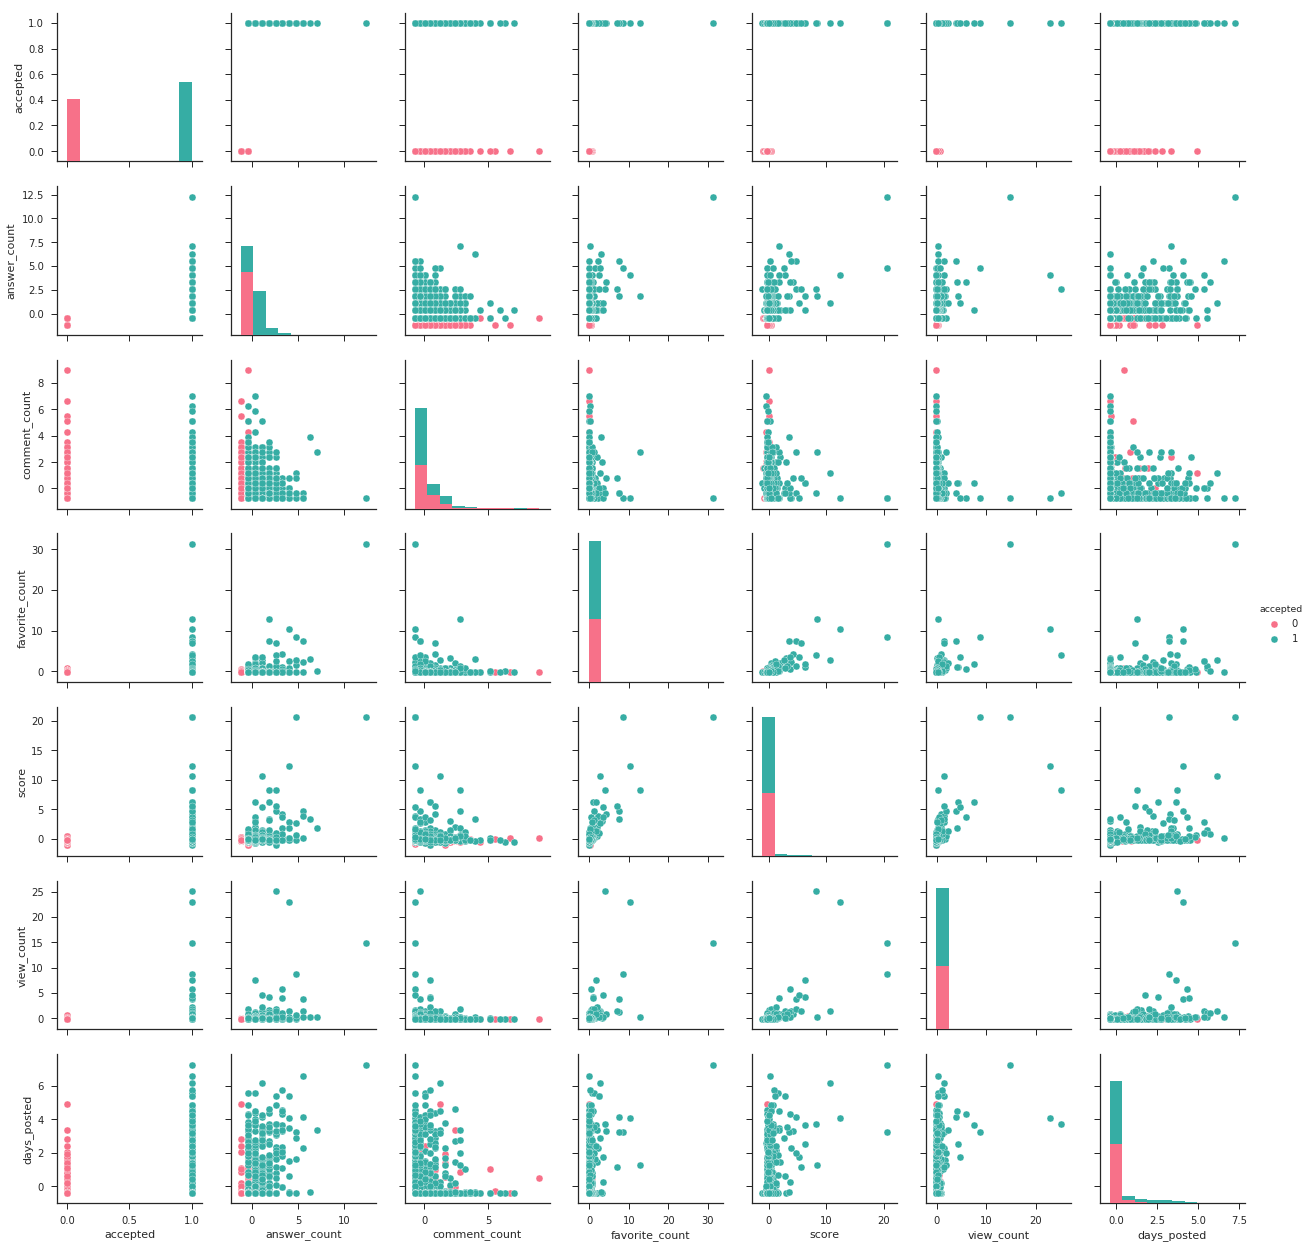

In [148]:
sns.pairplot(df_test_predictions, hue="accepted", palette="husl")